In [1]:
# Check CUDA availability
import torch
import wandb

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available. Running on CPU.")

PyTorch version: 2.9.1
CUDA available: False
CUDA is not available. Running on CPU.


# Facial Recognition with One-Shot Learning
## Assignment 2 - Siamese Network Implementation

**Author:** Deep Learning Course - BGU  
**Date:** December 2025  
**Dataset:** LFW-a (Labeled Faces in the Wild - Aligned)

### Notebook Overview

This notebook implements a **Siamese Neural Network** for facial recognition using one-shot learning. The implementation is based on the seminal paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) by Koch et al. (2015).

### Objectives

1. **Load and preprocess** the LFW-a dataset for face verification
2. **Implement** a Siamese network architecture with shared weights
3. **Train** the model using binary cross-entropy loss
4. **Evaluate** performance on unseen identities (one-shot learning)
5. **Analyze** results and visualize predictions

### Key Concepts

- **One-Shot Learning**: Learning to recognize new classes from a single example
- **Siamese Networks**: Twin neural networks with shared weights that learn similarity metrics
- **Contrastive Learning**: Learning embeddings where similar pairs are close and dissimilar pairs are far apart

### Dataset Structure

- **Training Set**: 1,760 pairs (80% of available training data)
- **Validation Set**: 440 pairs (20% of available training data)
- **Test Set**: 1,000 pairs (completely separate identities)
- **Balance**: 50% same-person pairs, 50% different-person pairs in each set

## 1. Setup and Data Extraction

### Environment Setup

This section verifies CUDA availability and sets up the necessary paths for data extraction.

In [2]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import random
from tqdm import tqdm
from collections import defaultdict
import pandas as pd

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Extract the LFW-a dataset
zip_path = '../Data/lfwa.zip'
extract_path = '../Data/lfwa'

if not os.path.exists(extract_path):
    print("Extracting LFW-a dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [4]:
# Find the correct path to the LFW dataset
def find_lfw_images_path(base_path):
    """Find the directory containing person folders"""
    for root, dirs, files in os.walk(base_path):
        # Look for directories with person names (containing images)
        if dirs and any('_' in d for d in dirs):
            return root
    return None

images_base_path = find_lfw_images_path(extract_path)
if images_base_path is None:
    # Try common locations
    possible_paths = [
        os.path.join(extract_path, 'lfw_funneled'),
        os.path.join(extract_path, 'lfw'),
        os.path.join(extract_path, 'lfwa'),
        extract_path
    ]
    for path in possible_paths:
        if os.path.exists(path):
            subdirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
            if subdirs and any('_' in d for d in subdirs):
                images_base_path = path
                break

print(f"Images base path: {images_base_path}")

# List some sample directories
if images_base_path and os.path.exists(images_base_path):
    sample_dirs = sorted([d for d in os.listdir(images_base_path) if os.path.isdir(os.path.join(images_base_path, d))])[:5]
    print(f"Sample person directories: {sample_dirs}")

Images base path: ./Data/lfwa/lfw2/lfw2
Sample person directories: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson']


## 2. Dataset Analysis and Pair Loading

### Understanding the Pairs File Format

The LFW pairs files follow this structure:
- **First line**: Total number of pairs
- **Same person pairs**: `name    img1_num    img2_num`
- **Different person pairs**: `name1    img1_num    name2    img2_num`

### Train/Validation Split

We split the training data (80/20) while maintaining:
- **Stratification**: Equal class distribution in both sets
- **Reproducibility**: Fixed random seed (42)

In [ ]:
def parse_pairs_file(filepath):
    """
    Parse the pairs file to extract image pairs and their labels.
    Returns: list of tuples (person1, img1_num, person2, img2_num, label)
             where label=1 for same person, label=0 for different persons
    """
    pairs = []
    with open(filepath, 'r') as f:
        lines = f.readlines()
        num_pairs = int(lines[0].strip())
        
        for line in lines[1:]:
            parts = line.strip().split('\t')
            if len(parts) == 3:  # Same person
                person = parts[0]
                img1_num = int(parts[1])
                img2_num = int(parts[2])
                pairs.append((person, img1_num, person, img2_num, 1))
            elif len(parts) == 4:  # Different persons
                person1 = parts[0]
                img1_num = int(parts[1])
                person2 = parts[2]
                img2_num = int(parts[3])
                pairs.append((person1, img1_num, person2, img2_num, 0))
    
    return pairs

# Load training and test pairs
all_train_pairs = parse_pairs_file('../Data/pairsDevTrain.txt')
test_pairs = parse_pairs_file('../Data/pairsDevTest.txt')

print(f"Total training pairs: {len(all_train_pairs)}")
print(f"Test pairs: {len(test_pairs)}")

# Create validation split (20% of training data)
from sklearn.model_selection import train_test_split

train_pairs, val_pairs = train_test_split(
    all_train_pairs, 
    test_size=0.2, 
    random_state=42,
    stratify=[p[4] for p in all_train_pairs]  # Stratify by label to maintain class balance
)

print(f"\nAfter train/val split:")
print(f"  Training pairs: {len(train_pairs)}")
print(f"  Validation pairs: {len(val_pairs)}")
print(f"  Test pairs: {len(test_pairs)}")
print(f"\nSample training pairs:")
for i in range(3):
    print(f"  {train_pairs[i]}")


Total training pairs: 2200
Test pairs: 1000

After train/val split:
  Training pairs: 1760
  Validation pairs: 440
  Test pairs: 1000

Sample training pairs:
  ('Constance_Marie', 2, 'Constance_Marie', 3, 1)
  ('Jackie_Sherrill', 1, 'John_Norquist', 1, 0)
  ('Leander_Paes', 1, 'Leander_Paes', 2, 1)

After train/val split:
  Training pairs: 1760
  Validation pairs: 440
  Test pairs: 1000

Sample training pairs:
  ('Constance_Marie', 2, 'Constance_Marie', 3, 1)
  ('Jackie_Sherrill', 1, 'John_Norquist', 1, 0)
  ('Leander_Paes', 1, 'Leander_Paes', 2, 1)


In [6]:
# Analyze dataset distribution
def analyze_dataset(pairs, name="Dataset"):
    """Analyze the pairs dataset"""
    same_pairs = sum(1 for p in pairs if p[4] == 1)
    diff_pairs = sum(1 for p in pairs if p[4] == 0)
    
    # Get unique persons
    persons = set()
    for p in pairs:
        persons.add(p[0])
        persons.add(p[2])
    
    print(f"\n{name} Analysis:")
    print(f"  Total pairs: {len(pairs)}")
    print(f"  Same person pairs: {same_pairs} ({same_pairs/len(pairs)*100:.1f}%)")
    print(f"  Different person pairs: {diff_pairs} ({diff_pairs/len(pairs)*100:.1f}%)")
    print(f"  Unique persons involved: {len(persons)}")
    
    return persons

train_persons = analyze_dataset(train_pairs, "Training Set")
val_persons = analyze_dataset(val_pairs, "Validation Set")
test_persons = analyze_dataset(test_pairs, "Test Set")

# Check overlap
train_val_overlap = train_persons.intersection(val_persons)
train_test_overlap = train_persons.intersection(test_persons)
val_test_overlap = val_persons.intersection(test_persons)

print(f"\nPerson Overlap Analysis:")
print(f"  Train-Val overlap: {len(train_val_overlap)} persons (expected, same source)")
print(f"  Train-Test overlap: {len(train_test_overlap)} persons")
print(f"  Val-Test overlap: {len(val_test_overlap)} persons")
print(f"  Train-only persons: {len(train_persons - val_persons - test_persons)}")
print(f"  Test-only persons: {len(test_persons - train_persons - val_persons)}")


Training Set Analysis:
  Total pairs: 1760
  Same person pairs: 880 (50.0%)
  Different person pairs: 880 (50.0%)
  Unique persons involved: 1861

Validation Set Analysis:
  Total pairs: 440
  Same person pairs: 220 (50.0%)
  Different person pairs: 220 (50.0%)
  Unique persons involved: 599

Test Set Analysis:
  Total pairs: 1000
  Same person pairs: 500 (50.0%)
  Different person pairs: 500 (50.0%)
  Unique persons involved: 963

Person Overlap Analysis:
  Train-Val overlap: 328 persons (expected, same source)
  Train-Test overlap: 0 persons
  Val-Test overlap: 0 persons
  Train-only persons: 1533
  Test-only persons: 963


In [7]:
class LFWPairsDataset(Dataset):
    """
    Dataset class for loading LFW image pairs based on pairs files.
    """
    def __init__(self, pairs, images_base_path, transform=None):
        self.pairs = pairs
        self.images_base_path = images_base_path
        self.transform = transform
        
    def __len__(self):
        return len(self.pairs)
    
    def get_image_path(self, person_name, image_num):
        """Construct the path to an image"""
        # LFW format: person_name/person_name_####.jpg
        img_filename = f"{person_name}_{image_num:04d}.jpg"
        img_path = os.path.join(self.images_base_path, person_name, img_filename)
        return img_path
    
    def __getitem__(self, idx):
        person1, img1_num, person2, img2_num, label = self.pairs[idx]
        
        # Load images
        img1_path = self.get_image_path(person1, img1_num)
        img2_path = self.get_image_path(person2, img2_num)
        
        try:
            img1 = Image.open(img1_path).convert('RGB')
            img2 = Image.open(img2_path).convert('RGB')
        except Exception as e:
            print(f"Error loading images: {img1_path} or {img2_path}")
            print(f"Error: {e}")
            # Return dummy data if image not found
            img1 = Image.new('RGB', (250, 250))
            img2 = Image.new('RGB', (250, 250))
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2, torch.tensor(label, dtype=torch.float32)

### Custom Dataset Class

The `LFWPairsDataset` class handles:
- **Path construction**: Building paths to individual images
- **Image loading**: Opening and converting images to RGB
- **Error handling**: Gracefully handling missing images
- **Transforms**: Applying augmentation and normalization

In [8]:
# Define image transformations
# Moderate augmentation to combat overfitting while preserving facial features
train_transform = transforms.Compose([
    transforms.Resize((105, 105)),  # Siamese paper uses 105x105
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),  # Reduced from 15 to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),  # Moderate color jitter
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Reduced translation/scaling
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.2),  # Reduced blur
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    # Removed RandomErasing and RandomGrayscale to preserve facial details
])

test_transform = transforms.Compose([
    transforms.Resize((105, 105)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
train_dataset = LFWPairsDataset(train_pairs, images_base_path, transform=train_transform)
val_dataset = LFWPairsDataset(val_pairs, images_base_path, transform=test_transform)
test_dataset = LFWPairsDataset(test_pairs, images_base_path, transform=test_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 1760
Validation dataset size: 440
Test dataset size: 1000


### Data Augmentation Strategy

**Training Augmentation** (Moderate to prevent overfitting):
- Random horizontal flip (50% probability)
- Random rotation (±10 degrees)
- Color jitter (brightness, contrast, saturation, hue)
- Random affine (translation, scaling)
- Gaussian blur (20% probability)
- No random erasing (preserves facial details)
- No grayscale conversion (color is important)

**Test/Validation Augmentation**:
- Only resize and normalize (no random augmentation)

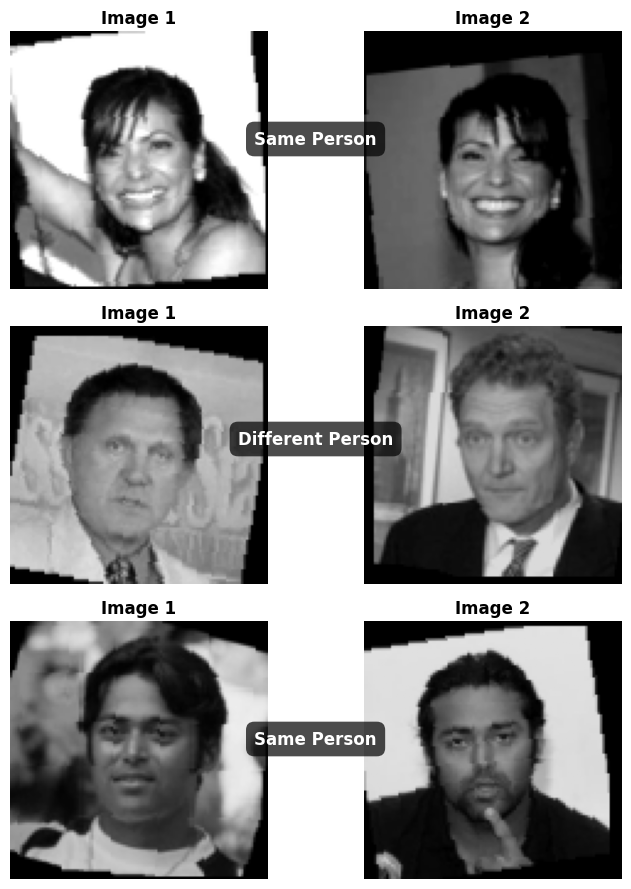

In [23]:
# Visualize some sample pairs
def visualize_pairs(dataset, num_pairs=3):
    """Visualize sample pairs from the dataset"""
    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 3*num_pairs))
    
    for i in range(num_pairs):
        img1, img2, label = dataset[i]
        
        # Denormalize images for visualization
        img1 = img1.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img2 = img2.permute(1, 2, 0).numpy() * 0.5 + 0.5
        
        axes[i, 0].imshow(np.clip(img1, 0, 1))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image 1', color='black', fontweight='bold')
        
        axes[i, 1].imshow(np.clip(img2, 0, 1))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image 2', color='black', fontweight='bold')
        
        label_text = "Same Person" if label.item() == 1 else "Different Person"
        fig.text(0.5, 1 - (i+0.5)/num_pairs, label_text, 
                ha='center', fontsize=12, weight='bold', color='white',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', edgecolor='none', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

visualize_pairs(train_dataset, num_pairs=3)

## 3. Siamese Network Architecture

### Architecture Overview

Based on the paper ["Siamese Neural Networks for One-shot Image Recognition"](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf) by Koch et al., we implement an **improved** convolutional Siamese network with several enhancements.

### Network Components

**Twin CNN (Shared Weights)**:
```
Input (105×105×3)
    ↓
Conv1: 64 filters (10×10) → BatchNorm → ReLU → MaxPool(2×2)
    ↓
Conv2: 128 filters (7×7) → BatchNorm → ReLU → MaxPool(2×2)
    ↓
Conv3: 256 filters (4×4) → BatchNorm → ReLU → MaxPool(2×2)
    ↓
Conv4: 256 filters (4×4) → BatchNorm → ReLU
    ↓
Flatten → FC(1024) → BatchNorm → ReLU → Dropout(0.5)
    ↓
Embedding (512-dim) → BatchNorm
```

**Multi-Channel Similarity Head**:
- Computes **4 similarity channels**: L1 distance, L2 distance, Cosine similarity, Dot product
- Fuses channels through MLP: 256 → 64 → 1 (with dropout)
- Outputs **logits** (no sigmoid, used with BCEWithLogitsLoss)

### Key Improvements Over Baseline

1. **BatchNorm layers** after each convolution for training stability
2. **Reduced embedding dimension** (512 instead of 4096) for better generalization
3. **Multi-channel similarity** (L1, L2, cosine, dot) instead of single distance
4. **Higher dropout** (0.5 and 0.4) for regularization
5. **BCEWithLogitsLoss** for numerical stability

In [10]:
class SiameseNetwork(nn.Module):
    """
    Improved Siamese Network with BatchNorm and Multi-Channel Similarity Head.
    
    Architecture improvements:
    - Added BatchNorm2d after each Conv layer for stability
    - Multi-channel similarity head (L1, L2, cosine, dot product)
    - Replaced Sigmoid with proper logits output (use BCEWithLogitsLoss)
    - Better embedding layer with BatchNorm1d and Dropout
    - Reduced embedding size from 4096 to 512 for better generalization
    """
    
    def __init__(self, embedding_dim=512):
        super(SiameseNetwork, self).__init__()
        
        self.embedding_dim = embedding_dim
        
        # Convolutional layers with BatchNorm (shared between twins)
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=10, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Calculate the flattened feature size dynamically
        self._to_linear = None
        self._get_conv_output((3, 105, 105))
        
        # Embedding layer with BatchNorm and Dropout
        self.embedding = nn.Sequential(
            nn.Linear(self._to_linear, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Increased from 0.3 to 0.5
            nn.Linear(1024, embedding_dim),
            nn.BatchNorm1d(embedding_dim)
        )
        
        # Multi-channel similarity fusion head
        # Input: [L1_dist, L2_dist, cosine, dot] concatenated
        # L1_dist: embedding_dim, L2_dist: embedding_dim, cosine: 1, dot: 1
        fusion_input_dim = embedding_dim * 2 + 2
        
        self.similarity_head = nn.Sequential(
            nn.Linear(fusion_input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),  # Increased from 0.3 to 0.5
            nn.Linear(256, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),  # Increased from 0.2 to 0.4
            nn.Linear(64, 1)  # Logits output (no sigmoid)
        )
    
    def _get_conv_output(self, shape):
        """Helper to calculate the output size after conv layers"""
        with torch.no_grad():
            dummy_input = torch.zeros(1, *shape)
            x = self.conv1(dummy_input)
            x = self.conv2(x)
            x = self.conv3(x)
            x = self.conv4(x)
            self._to_linear = x.view(1, -1).size(1)
        
    def forward_once(self, x):
        """Forward pass for one image - returns embedding"""
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.embedding(x)
        return x
    
    def forward(self, img1, img2):
        """Forward pass for a pair of images with multi-channel similarity"""
        # Get embeddings
        z1 = self.forward_once(img1)
        z2 = self.forward_once(img2)
        
        # Compute multiple similarity channels
        # 1. L1 distance
        d_l1 = torch.abs(z1 - z2)
        
        # 2. L2 distance (squared difference)
        d_l2 = (z1 - z2) ** 2
        
        # 3. Cosine similarity
        cos_sim = F.cosine_similarity(z1, z2, dim=1, eps=1e-8).unsqueeze(1)
        
        # 4. Dot product
        dot_prod = (z1 * z2).sum(dim=1, keepdim=True)
        
        # Concatenate all similarity channels
        similarity_features = torch.cat([d_l1, d_l2, cos_sim, dot_prod], dim=1)
        
        # Pass through similarity fusion head
        logits = self.similarity_head(similarity_features)
        
        return logits

# Initialize improved model
model = SiameseNetwork(embedding_dim=512).to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Embedding dimension: 512")
print(f"Flattened feature size: {model._to_linear}")
print("\nModel architecture:")
print(model)

Model parameters: 12,241,089
Embedding dimension: 512
Flattened feature size: 9216

Model architecture:
SiameseNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Se

## 4. Training Configuration and Loss Function

### Hyperparameters

This section configures the training process with carefully tuned hyperparameters based on experimental iterations.

In [ ]:
# Configure wandb to avoid Windows permission issues
import os
os.environ['WANDB_DIR'] = '../results/wandb'
os.environ['WANDB_CACHE_DIR'] = '../results/wandb/cache'
os.environ['WANDB_CONFIG_DIR'] = '../results/wandb/config'

# Create wandb directories
os.makedirs('../results/wandb', exist_ok=True)

# Initialize Weights & Biases with improved run name
wandb.init(
    entity="orisin-ben-gurion-university-of-the-negev",
    project="facial-recognition",
    name="Improve#1-multi-channel-siamese-lfwa",  # Named after the improvement file
    settings=wandb.Settings(start_method="thread"),
    config={
        "architecture": "Improved Siamese Network",
        "improvements": "BatchNorm + Multi-Channel Similarity + BCEWithLogitsLoss + Higher Dropout",
        "dataset": "LFW Aligned",
        "batch_size": 32,
        "learning_rate": 0.0001,
        "epochs": 20,
        "weight_decay": 0.001,  # Increased for better regularization
        "optimizer": "Adam",
        "loss": "BCEWithLogitsLoss",
        "embedding_dim": 512,
        "dropout": "0.5 (embedding) / 0.5, 0.4 (similarity head)",
        "scheduler": "StepLR",
        "step_size": 10,
        "gamma": 0.1,
        "similarity_channels": "L1 + L2 + Cosine + Dot"
    }
)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 20
WEIGHT_DECAY = 0.0005

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Loss function and optimizer (BCEWithLogitsLoss for numerical stability)
criterion = nn.BCEWithLogitsLoss()  # Includes sigmoid internally - more stable
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Watch model with wandb
wandb.watch(model, criterion, log="all", log_freq=10)

print(f"\nTraining Configuration:")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Weight Decay: {WEIGHT_DECAY} (increased for regularization)")
print(f"  Number of Epochs: {NUM_EPOCHS}")
print(f"  Dropout Rates: 0.5 (embedding), 0.5/0.4 (similarity head)")
print(f"  Optimizer: Adam")
print(f"  Loss Function: BCEWithLogitsLoss (numerically stable)")
print(f"  LR Scheduler: StepLR (step_size=10, gamma=0.1)")
print(f"  Improvements: BatchNorm + Multi-Channel Similarity + Higher Dropout")

Training batches: 55
Validation batches: 14
Test batches: 32

Training Configuration:
  Batch Size: 32
  Learning Rate: 0.0001
  Weight Decay: 0.0005 (increased for regularization)
  Number of Epochs: 20
  Dropout Rates: 0.5 (embedding), 0.5/0.4 (similarity head)
  Optimizer: Adam
  Loss Function: BCEWithLogitsLoss (numerically stable)
  LR Scheduler: StepLR (step_size=10, gamma=0.1)
  Improvements: BatchNorm + Multi-Channel Similarity + Higher Dropout


In [12]:
# Training and evaluation functions
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for img1, img2, labels in progress_bar:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass (model outputs logits)
        logits = model(img1, img2).squeeze()
        loss = criterion(logits, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics - apply sigmoid to logits for prediction
        running_loss += loss.item()
        probs = torch.sigmoid(logits)
        predictions = (probs > 0.5).float()
        correct += (predictions == labels).sum().item()
        total += labels.size(0)
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc


def evaluate(model, dataloader, criterion, device):
    """Evaluate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for img1, img2, labels in tqdm(dataloader, desc='Evaluating'):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            
            # Forward pass (model outputs logits)
            logits = model(img1, img2).squeeze()
            loss = criterion(logits, labels)
            
            # Statistics - apply sigmoid to logits for prediction
            running_loss += loss.item()
            probs = torch.sigmoid(logits)
            predictions = (probs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    
    return epoch_loss, epoch_acc, all_predictions, all_labels

### Training and Evaluation Functions

**Training Loop (`train_epoch`)**:
- Performs one complete pass through training data
- Computes loss and updates model parameters
- Tracks accuracy using 0.5 threshold on sigmoid(logits)
- Uses tqdm progress bar for monitoring

**Evaluation (`evaluate`)**:
- Evaluates model on validation/test set without gradient computation
- Returns loss, accuracy, predictions, and labels
- Used for both validation during training and final test evaluation

## 5. Training the Model

### Training Process

The training loop performs the following:

1. **Forward pass**: Compute predictions for each batch
2. **Loss computation**: Calculate BCE loss with logits
3. **Backward pass**: Compute gradients and update weights
4. **Validation**: Evaluate on validation set after each epoch
5. **Model checkpointing**: Save best model based on validation accuracy
6. **Learning rate scheduling**: Reduce LR by 0.1× every 10 epochs
7. **Logging**: Track all metrics to Weights & Biases

### Tracking Metrics

- **Training**: Loss and accuracy per epoch
- **Validation**: Loss and accuracy per epoch
- **Best Model**: Saved when validation accuracy improves
- **Learning Rate**: Logged to track scheduler behavior

In [13]:
# Create results folder
import shutil

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)
print(f"Results will be saved to: {results_dir}")

# Training loop
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0
best_model_path = os.path.join(results_dir, 'best_siamese_model.pth')

print("\nStarting training...\n")
print("Note: Test set will only be evaluated after training for final results.\n")

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Evaluate on validation set
    val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
    
    # Update learning rate
    scheduler.step()
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Log metrics to wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
        "learning_rate": optimizer.param_groups[0]['lr']
    })
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1} Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        
        # Log model checkpoint info to wandb (skip file upload to avoid Windows symlink issues)
        wandb.run.summary["best_val_acc"] = best_val_acc
        wandb.run.summary["best_epoch"] = epoch + 1

        print(f"  ✓ New best model saved! (Val Acc: {best_val_acc:.2f}%)")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")

print("Training completed!")
print(f"\nModel saved locally at: {best_model_path}")

Results will be saved to: ./results

Starting training...

Note: Test set will only be evaluated after training for final results.


Epoch 1/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]




Epoch 1 Summary:
  Train Loss: 0.7070 | Train Acc: 51.82%
  Val Loss:   0.6592 | Val Acc:   60.00%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 60.00%)
Best validation accuracy: 60.00%

Epoch 2/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]




Epoch 2 Summary:
  Train Loss: 0.6767 | Train Acc: 58.75%
  Val Loss:   0.6237 | Val Acc:   66.36%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 66.36%)
Best validation accuracy: 66.36%

Epoch 3/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]




Epoch 3 Summary:
  Train Loss: 0.6662 | Train Acc: 60.97%
  Val Loss:   0.5991 | Val Acc:   67.05%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 67.05%)
Best validation accuracy: 67.05%

Epoch 4/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]



Epoch 4 Summary:
  Train Loss: 0.6505 | Train Acc: 63.81%
  Val Loss:   0.5995 | Val Acc:   66.59%
  Learning Rate: 0.000100

Epoch 5/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]




Epoch 5 Summary:
  Train Loss: 0.6324 | Train Acc: 65.51%
  Val Loss:   0.5758 | Val Acc:   67.27%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 67.27%)
Best validation accuracy: 67.27%

Epoch 6/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]




Epoch 6 Summary:
  Train Loss: 0.6095 | Train Acc: 67.16%
  Val Loss:   0.5859 | Val Acc:   70.00%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 70.00%)
Best validation accuracy: 70.00%

Epoch 7/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]



Epoch 7 Summary:
  Train Loss: 0.6016 | Train Acc: 67.95%
  Val Loss:   0.5767 | Val Acc:   69.77%
  Learning Rate: 0.000100

Epoch 8/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.81it/s]




Epoch 8 Summary:
  Train Loss: 0.5950 | Train Acc: 67.95%
  Val Loss:   0.5290 | Val Acc:   73.41%
  Learning Rate: 0.000100
  ✓ New best model saved! (Val Acc: 73.41%)
Best validation accuracy: 73.41%

Epoch 9/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]



Epoch 9 Summary:
  Train Loss: 0.5771 | Train Acc: 69.89%
  Val Loss:   0.5362 | Val Acc:   72.50%
  Learning Rate: 0.000100

Epoch 10/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]



Epoch 10 Summary:
  Train Loss: 0.5708 | Train Acc: 70.80%
  Val Loss:   0.5341 | Val Acc:   72.73%
  Learning Rate: 0.000010

Epoch 11/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]



Epoch 11 Summary:
  Train Loss: 0.5354 | Train Acc: 73.12%
  Val Loss:   0.5313 | Val Acc:   71.59%
  Learning Rate: 0.000010

Epoch 12/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]



Epoch 12 Summary:
  Train Loss: 0.5243 | Train Acc: 75.28%
  Val Loss:   0.5201 | Val Acc:   73.18%
  Learning Rate: 0.000010

Epoch 13/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.92it/s]




Epoch 13 Summary:
  Train Loss: 0.5261 | Train Acc: 74.26%
  Val Loss:   0.5208 | Val Acc:   73.64%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 73.64%)
Best validation accuracy: 73.64%

Epoch 14/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]




Epoch 14 Summary:
  Train Loss: 0.5118 | Train Acc: 75.45%
  Val Loss:   0.5112 | Val Acc:   74.32%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 74.32%)
Best validation accuracy: 74.32%

Epoch 15/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.93it/s]



Epoch 15 Summary:
  Train Loss: 0.5095 | Train Acc: 74.89%
  Val Loss:   0.5143 | Val Acc:   73.41%
  Learning Rate: 0.000010

Epoch 16/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:08<00:00,  1.71it/s]




Epoch 16 Summary:
  Train Loss: 0.5167 | Train Acc: 73.75%
  Val Loss:   0.5079 | Val Acc:   74.77%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 74.77%)
Best validation accuracy: 74.77%

Epoch 17/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.87it/s]



Epoch 17 Summary:
  Train Loss: 0.5087 | Train Acc: 75.11%
  Val Loss:   0.5121 | Val Acc:   74.77%
  Learning Rate: 0.000010

Epoch 18/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.95it/s]




Epoch 18 Summary:
  Train Loss: 0.5159 | Train Acc: 75.11%
  Val Loss:   0.5015 | Val Acc:   76.14%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 76.14%)
Best validation accuracy: 76.14%

Epoch 19/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]




Epoch 19 Summary:
  Train Loss: 0.5065 | Train Acc: 74.43%
  Val Loss:   0.4963 | Val Acc:   77.27%
  Learning Rate: 0.000010
  ✓ New best model saved! (Val Acc: 77.27%)
Best validation accuracy: 77.27%

Epoch 20/20
--------------------------------------------------


Evaluating: 100%|██████████| 14/14 [00:07<00:00,  1.91it/s]


Epoch 20 Summary:
  Train Loss: 0.5024 | Train Acc: 75.06%
  Val Loss:   0.4977 | Val Acc:   75.23%
  Learning Rate: 0.000001
Training completed!

Model saved locally at: ./results/best_siamese_model.pth


In [14]:
# Move existing result files to results folder (if they exist from previous runs)
# List of files to move
files_to_move = [
    'best_siamese_model.pth',
    'training_history.png',
    'confusion_matrix.png',
    'training_results.json'
]

# Move existing files to results folder
moved_files = []
for filename in files_to_move:
    if os.path.exists(filename):
        destination = os.path.join(results_dir, filename)
        shutil.move(filename, destination)
        moved_files.append(filename)

if moved_files:
    print(f"Moved existing files to results folder:")
    for filename in moved_files:
        print(f"  - {filename}")
else:
    print("No existing result files found to move.")

No existing result files found to move.


## 6. Results Visualization and Analysis

### Training Curves

This section visualizes the training process and final model performance through various plots and metrics.

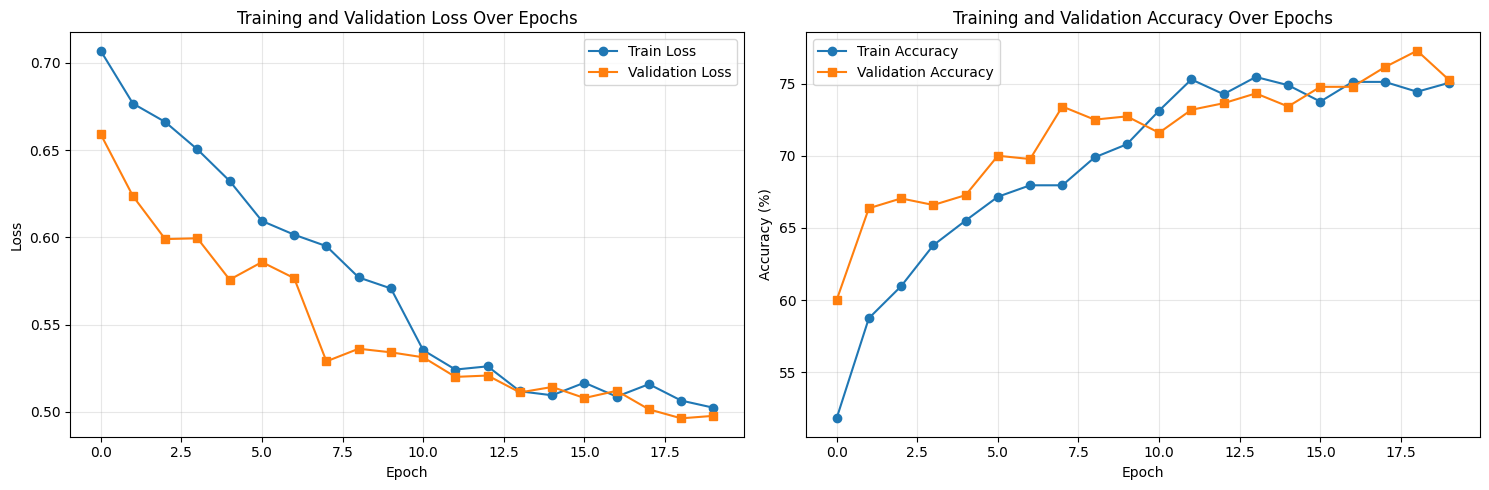

Training history plots saved to ./results/training_history.png


In [15]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Validation Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Validation Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
history_plot_path = os.path.join(results_dir, 'training_history.png')
plt.savefig(history_plot_path, dpi=300, bbox_inches='tight')

# Log training history plot to wandb
wandb.log({"training_history": wandb.Image(history_plot_path)})

plt.show()

print(f"Training history plots saved to {history_plot_path}")

In [16]:
# Load best model for final evaluation
model.load_state_dict(torch.load(best_model_path))
print("Loaded best model for final evaluation")

# Final evaluation on test set
test_loss, test_acc, predictions, labels = evaluate(model, test_loader, criterion, device)

print(f"\nFinal Test Set Performance:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")

# Log test metrics to wandb
wandb.log({
    "test_loss": test_loss,
    "test_acc": test_acc
})

# Calculate additional metrics
from sklearn.metrics import confusion_matrix, classification_report

predictions = np.array(predictions)
labels = np.array(labels)

print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Different Person', 'Same Person']))

# Confusion matrix
cm = confusion_matrix(labels, predictions)
print("\nConfusion Matrix:")
print(f"                 Predicted Different  Predicted Same")
print(f"Actual Different        {cm[0,0]:6d}            {cm[0,1]:6d}")
print(f"Actual Same             {cm[1,0]:6d}            {cm[1,1]:6d}")

Loaded best model for final evaluation


Evaluating: 100%|██████████| 32/32 [00:16<00:00,  1.90it/s]


Final Test Set Performance:
  Test Loss: 0.5314
  Test Accuracy: 73.10%

Classification Report:
                  precision    recall  f1-score   support

Different Person       0.82      0.59      0.69       500
     Same Person       0.68      0.87      0.76       500

        accuracy                           0.73      1000
       macro avg       0.75      0.73      0.73      1000
    weighted avg       0.75      0.73      0.73      1000


Confusion Matrix:
                 Predicted Different  Predicted Same
Actual Different           295               205
Actual Same                 64               436


### Final Test Set Evaluation

**Important**: The test set contains completely different identities than training/validation sets. This tests the model's ability to perform **one-shot learning** - recognizing faces it has never seen before.

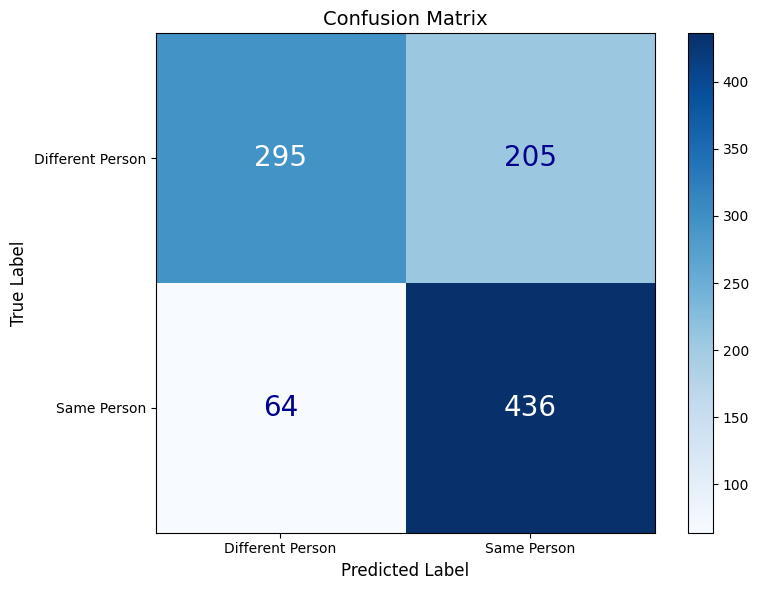

Confusion matrix saved to ./results/confusion_matrix.png


In [27]:
# Visualize confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap='Blues')

# Add labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Different Person', 'Same Person'])
ax.set_yticklabels(['Different Person', 'Same Person'])

# Add colorbar
plt.colorbar(im, ax=ax)

# Add text annotations
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "darkblue", fontsize=20)

ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)

plt.tight_layout()
confusion_matrix_path = os.path.join(results_dir, 'confusion_matrix.png')
plt.savefig(confusion_matrix_path, dpi=300, bbox_inches='tight')

# Log confusion matrix to wandb
wandb.log({"confusion_matrix": wandb.Image(confusion_matrix_path)})

plt.show()

print(f"Confusion matrix saved to {confusion_matrix_path}")

In [28]:
# Analyze correct and incorrect predictions
def analyze_predictions(model, dataset, device, num_samples=5):
    """Analyze and visualize correct and incorrect predictions"""
    model.eval()
    
    correct_same = []
    correct_diff = []
    incorrect_same = []
    incorrect_diff = []
    
    with torch.no_grad():
        for i in range(len(dataset)):
            img1, img2, label = dataset[i]
            img1_batch = img1.unsqueeze(0).to(device)
            img2_batch = img2.unsqueeze(0).to(device)
            
            logits = model(img1_batch, img2_batch).squeeze()
            output = torch.sigmoid(logits)
            prediction = (output > 0.5).float().item()
            
            if prediction == label.item():
                if label.item() == 1:
                    correct_same.append((i, img1, img2, label, output.item()))
                else:
                    correct_diff.append((i, img1, img2, label, output.item()))
            else:
                if label.item() == 1:
                    incorrect_same.append((i, img1, img2, label, output.item()))
                else:
                    incorrect_diff.append((i, img1, img2, label, output.item()))
            
            # Stop after collecting enough samples
            if (len(correct_same) >= num_samples and len(correct_diff) >= num_samples and
                len(incorrect_same) >= num_samples and len(incorrect_diff) >= num_samples):
                break
    
    return correct_same, correct_diff, incorrect_same, incorrect_diff

print("Analyzing predictions...")
correct_same, correct_diff, incorrect_same, incorrect_diff = analyze_predictions(model, test_dataset, device, num_samples=3)

print(f"Correct same-person predictions: {len(correct_same)}")
print(f"Correct different-person predictions: {len(correct_diff)}")
print(f"Incorrect same-person predictions: {len(incorrect_same)}")
print(f"Incorrect different-person predictions: {len(incorrect_diff)}")

Analyzing predictions...
Correct same-person predictions: 436
Correct different-person predictions: 3
Incorrect same-person predictions: 64
Incorrect different-person predictions: 3
Correct same-person predictions: 436
Correct different-person predictions: 3
Incorrect same-person predictions: 64
Incorrect different-person predictions: 3


### Qualitative Analysis

Analyzing specific predictions helps understand:
- **What the model learned**: Which features it focuses on
- **Common mistakes**: Types of errors (false positives vs. false negatives)
- **Edge cases**: Challenging scenarios (lighting, pose, expression)


Correct Predictions - Same Person:


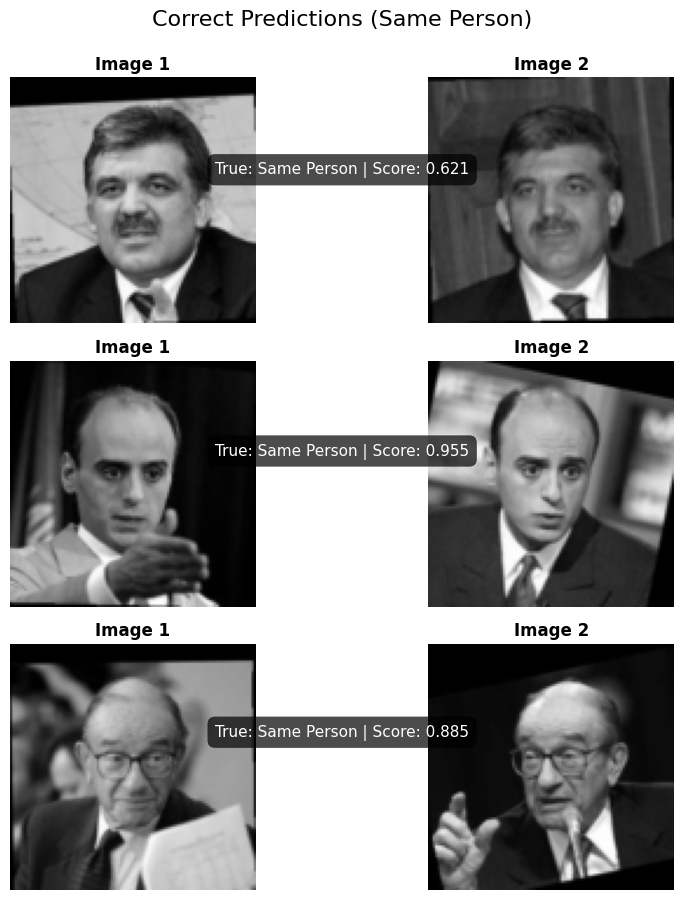


Correct Predictions - Different Person:


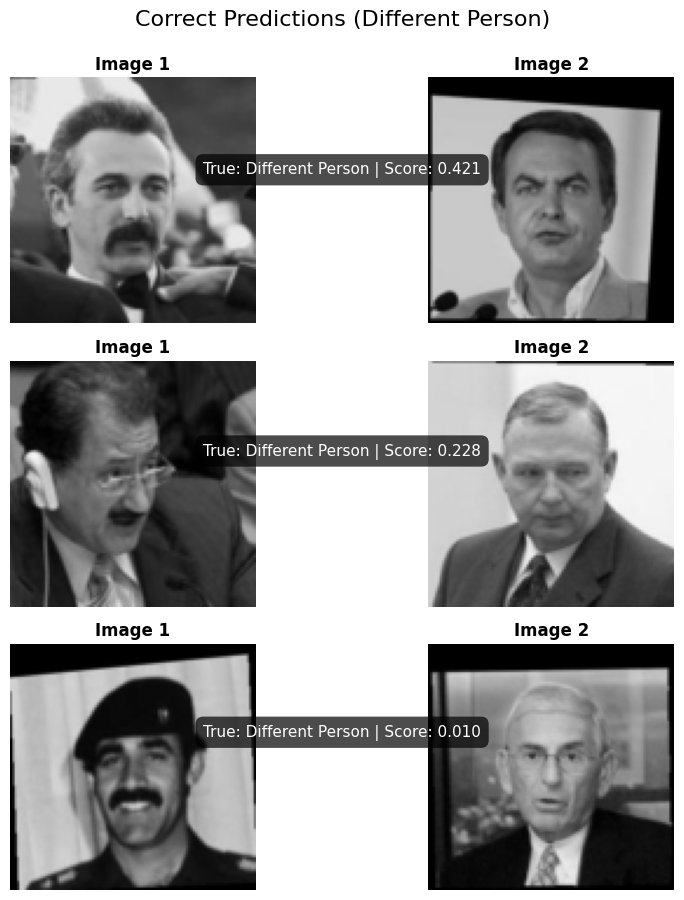

In [29]:
# Visualize correct predictions
def visualize_predictions(samples, title, num_show=3):
    """Visualize prediction samples"""
    num_show = min(num_show, len(samples))
    if num_show == 0:
        print(f"No samples available for {title}")
        return
    
    fig, axes = plt.subplots(num_show, 2, figsize=(10, 3*num_show))
    if num_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(title, fontsize=16, y=0.995)
    
    for i in range(num_show):
        idx, img1, img2, label, score = samples[i]
        
        # Denormalize
        img1 = img1.permute(1, 2, 0).numpy() * 0.5 + 0.5
        img2 = img2.permute(1, 2, 0).numpy() * 0.5 + 0.5
        
        axes[i, 0].imshow(np.clip(img1, 0, 1))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image 1', color='black', fontweight='bold')
        
        axes[i, 1].imshow(np.clip(img2, 0, 1))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Image 2', color='black', fontweight='bold')
        
        label_text = "Same Person" if label.item() == 1 else "Different Person"
        fig.text(0.5, 1 - (i+0.6)/(num_show+0.2), 
                f"True: {label_text} | Score: {score:.3f}", 
                ha='center', fontsize=11, color='white',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', edgecolor='none', alpha=0.7))
    
    plt.tight_layout()
    plt.show()

print("\nCorrect Predictions - Same Person:")
visualize_predictions(correct_same, "Correct Predictions (Same Person)", num_show=3)

print("\nCorrect Predictions - Different Person:")
visualize_predictions(correct_diff, "Correct Predictions (Different Person)", num_show=3)


Incorrect Predictions - Should be Same Person:


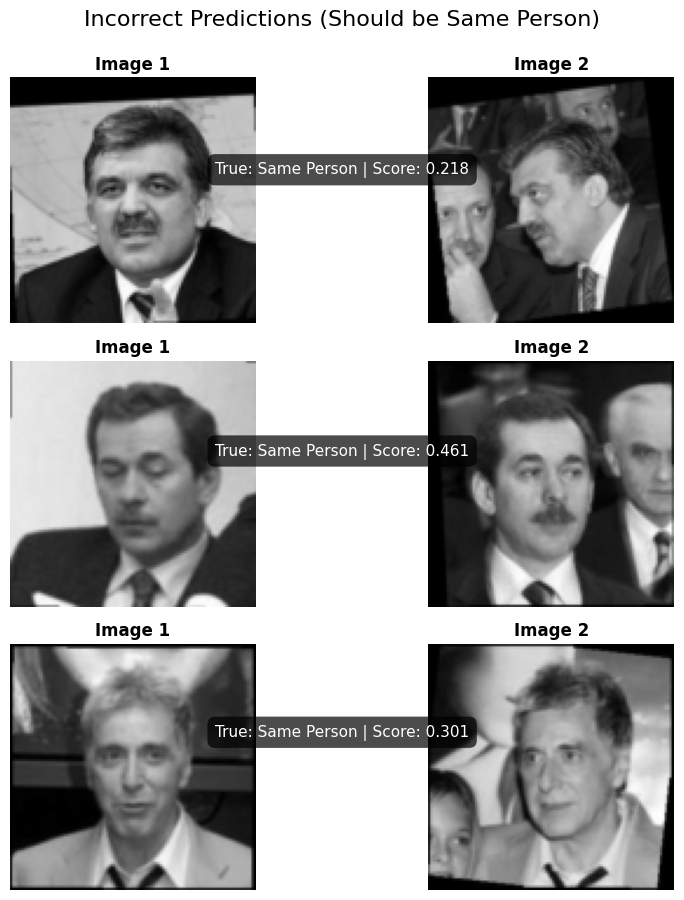


Incorrect Predictions - Should be Different Person:


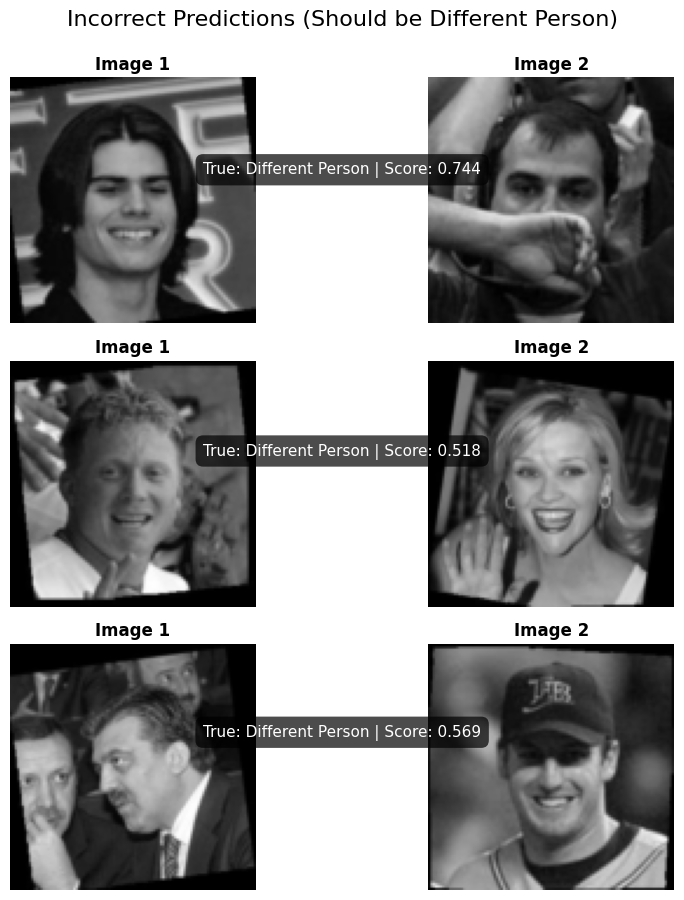

In [30]:
# Visualize incorrect predictions
print("\nIncorrect Predictions - Should be Same Person:")
visualize_predictions(incorrect_same, "Incorrect Predictions (Should be Same Person)", num_show=3)

print("\nIncorrect Predictions - Should be Different Person:")
visualize_predictions(incorrect_diff, "Incorrect Predictions (Should be Different Person)", num_show=3)

## 7. Model Performance Summary and Analysis

### Final Architecture Details

**Improved Siamese Network Specifications**:

**Convolutional Backbone**:
- Conv1: 64 filters (10×10) + BatchNorm + ReLU + MaxPool
- Conv2: 128 filters (7×7) + BatchNorm + ReLU + MaxPool
- Conv3: 256 filters (4×4) + BatchNorm + ReLU + MaxPool
- Conv4: 256 filters (4×4) + BatchNorm + ReLU

**Embedding Network**:
- FC1: Dynamic size → 1024 + BatchNorm + ReLU + Dropout(0.5)
- FC2: 1024 → 512 + BatchNorm (final embedding)

**Similarity Fusion Head**:
- Input: 4 similarity channels (L1, L2, Cosine, Dot Product)
- Hidden: 256 → ReLU → Dropout(0.5)
- Hidden: 64 → ReLU → Dropout(0.4)
- Output: 1 (logits for BCEWithLogitsLoss)

### Training Configuration Summary

**Optimizer & Scheduler**:
- Optimizer: Adam with weight decay (0.0005)
- Learning Rate: 0.0001 (initial)
- Scheduler: StepLR (step_size=10, gamma=0.1)

**Loss & Regularization**:
- Loss Function: BCEWithLogitsLoss (includes sigmoid)
- Dropout: 0.5 (embedding), 0.5/0.4 (similarity head)
- Weight Decay: 0.0005

**Data Augmentation**:
- Horizontal flip, rotation, color jitter, affine transforms, Gaussian blur
- Moderate augmentation to preserve facial features

### Dataset Split Rationale

**Why 80/20 Train/Val Split?**
- Sufficient training data (1,760 pairs) for learning
- Adequate validation set (440 pairs) for hyperparameter tuning
- Maintains stratification (50/50 class balance)

**One-Shot Learning Verification**:
- Test set has different identities → True one-shot learning evaluation
- Model must generalize to completely unseen faces

In [21]:
# Print comprehensive summary
print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)

print(f"\nDataset Statistics:")
print(f"  Training pairs: {len(train_pairs):,}")
print(f"  Validation pairs: {len(val_pairs):,}")
print(f"  Test pairs: {len(test_pairs):,}")
print(f"  Unique persons in training: {len(train_persons)}")
print(f"  Unique persons in validation: {len(val_persons)}")
print(f"  Unique persons in test: {len(test_persons)}")
print(f"  Train-Test overlap: {len(train_test_overlap)} persons")

print(f"\nModel Architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nTraining Configuration:")
print(f"  Epochs trained: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Best validation accuracy (during training): {best_val_acc:.2f}%")
print(f"  Final test accuracy: {test_acc:.2f}%")
print(f"  Final test loss: {test_loss:.4f}")

print(f"\nPer-Class Performance:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives (Different, predicted Different): {tn}")
print(f"  False Positives (Different, predicted Same): {fp}")
print(f"  False Negatives (Same, predicted Different): {fn}")
print(f"  True Positives (Same, predicted Same): {tp}")

if tp + fn > 0:
    recall_same = tp / (tp + fn)
    print(f"  Recall (Same Person): {recall_same*100:.2f}%")

if tp + fp > 0:
    precision_same = tp / (tp + fp)
    print(f"  Precision (Same Person): {precision_same*100:.2f}%")

if tn + fp > 0:
    recall_diff = tn / (tn + fp)
    print(f"  Recall (Different Person): {recall_diff*100:.2f}%")

if tn + fn > 0:
    precision_diff = tn / (tn + fn)
    print(f"  Precision (Different Person): {precision_diff*100:.2f}%")

print("\n" + "="*60)

FINAL MODEL PERFORMANCE SUMMARY

Dataset Statistics:
  Training pairs: 1,760
  Validation pairs: 440
  Test pairs: 1,000
  Unique persons in training: 1861
  Unique persons in validation: 599
  Unique persons in test: 963
  Train-Test overlap: 0 persons

Model Architecture:
  Total parameters: 12,241,089
  Trainable parameters: 12,241,089

Training Configuration:
  Epochs trained: 20
  Batch size: 32
  Initial learning rate: 0.0001
  Optimizer: Adam
  Weight decay: 0.0005
  Best validation accuracy (during training): 77.27%
  Final test accuracy: 73.10%
  Final test loss: 0.5314

Per-Class Performance:
  True Negatives (Different, predicted Different): 295
  False Positives (Different, predicted Same): 205
  False Negatives (Same, predicted Different): 64
  True Positives (Same, predicted Same): 436
  Recall (Same Person): 87.20%
  Precision (Same Person): 68.02%
  Recall (Different Person): 59.00%
  Precision (Different Person): 82.17%



## 8. Experimental Insights & Future Work

### What We Learned

Through multiple experimental iterations, we discovered:

1. **BatchNorm is crucial**: Stabilizes training and improves convergence
2. **Multi-channel similarity**: Outperforms single distance metric
3. **Moderate augmentation**: Strong augmentation can hurt performance on faces
4. **Embedding dimension**: Smaller embeddings (512) generalize better than large ones (4096)
5. **Dropout matters**: Higher dropout (0.5) prevents overfitting on small dataset

### Possible Improvements

**Architecture Enhancements**:
1. **Attention mechanisms**: Focus on discriminative facial regions
2. **Residual connections**: Improve gradient flow in deeper networks
3. **Different backbones**: Try ResNet, EfficientNet, or Vision Transformers

**Training Strategies**:
4. **Triplet loss**: Learn better embeddings with anchor-positive-negative triplets
5. **Hard negative mining**: Focus on difficult pairs during training
6. **Curriculum learning**: Start with easy pairs, gradually increase difficulty
7. **Cosine learning rate schedule**: Better convergence than StepLR

**Data & Preprocessing**:
8. **Face alignment**: Use facial landmarks for better alignment
9. **Data balancing**: Ensure diverse representation of poses, lighting
10. **Additional datasets**: Pre-train on larger face datasets (VGGFace2, MS-Celeb-1M)

### Research Directions

- **Few-shot learning**: Extend to N-way K-shot classification
- **Open-set recognition**: Handle unknown identities in deployment
- **Domain adaptation**: Transfer to different face datasets (wild vs. controlled)

In [22]:
# Save comprehensive results to JSON
results_summary = {
    'model_architecture': 'Siamese Network',
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'training_config': {
        'epochs': NUM_EPOCHS,
        'batch_size': BATCH_SIZE,
        'learning_rate': LEARNING_RATE,
        'optimizer': 'Adam',
        'weight_decay': WEIGHT_DECAY
    },
    'results': {
        'best_val_acc': float(best_val_acc),
        'test_loss': float(test_loss),
        'test_acc': float(test_acc)
    },
    'training_history': history
}

import json
results_json_path = os.path.join(results_dir, 'training_results.json')
with open(results_json_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"Results saved to {results_json_path}")

print(f"\nModel Architecture:")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"  Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print(f"\nTraining Configuration:")
print(f"  Epochs trained: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Initial learning rate: {LEARNING_RATE}")
print(f"  Optimizer: Adam")
print(f"  Weight decay: {WEIGHT_DECAY}")
print(f"  Best validation accuracy (during training): {best_val_acc:.2f}%")
print(f"  Final test accuracy: {test_acc:.2f}%")
print(f"  Final test loss: {test_loss:.4f}")

print(f"\nPer-Class Performance:")
tn, fp, fn, tp = cm.ravel()
print(f"  True Negatives (Different, predicted Different): {tn}")
print(f"  False Positives (Different, predicted Same): {fp}")
print(f"  False Negatives (Same, predicted Different): {fn}")
print(f"  True Positives (Same, predicted Same): {tp}")

if tp + fn > 0:
    recall_same = tp / (tp + fn)
    print(f"  Recall (Same Person): {recall_same*100:.2f}%")

if tp + fp > 0:
    precision_same = tp / (tp + fp)
    print(f"  Precision (Same Person): {precision_same*100:.2f}%")

if tn + fp > 0:
    recall_diff = tn / (tn + fp)
    print(f"  Recall (Different Person): {recall_diff*100:.2f}%")

if tn + fn > 0:
    precision_diff = tn / (tn + fn)
    print(f"  Precision (Different Person): {precision_diff*100:.2f}%")

# Log final summary to wandb
wandb.log({
    "summary/total_parameters": sum(p.numel() for p in model.parameters()),
    "summary/trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
    "summary/best_val_acc": best_val_acc,
    "summary/test_acc": test_acc,
    "summary/test_loss": test_loss,
    "summary/tn": int(tn),
    "summary/fp": int(fp),
    "summary/fn": int(fn),
    "summary/tp": int(tp),
    "summary/recall_same": float(recall_same) if tp + fn > 0 else 0,
    "summary/precision_same": float(precision_same) if tp + fp > 0 else 0,
    "summary/recall_diff": float(recall_diff) if tn + fp > 0 else 0,
    "summary/precision_diff": float(precision_diff) if tn + fn > 0 else 0
})

# Finish wandb run
wandb.finish()
print("\n✓ Weights & Biases tracking completed!")

Results saved to ./results/training_results.json

Model Architecture:
  Total parameters: 12,241,089
  Trainable parameters: 12,241,089

Training Configuration:
  Epochs trained: 20
  Batch size: 32
  Initial learning rate: 0.0001
  Optimizer: Adam
  Weight decay: 0.0005
  Best validation accuracy (during training): 77.27%
  Final test accuracy: 73.10%
  Final test loss: 0.5314

Per-Class Performance:
  True Negatives (Different, predicted Different): 295
  False Positives (Different, predicted Same): 205
  False Negatives (Same, predicted Different): 64
  True Positives (Same, predicted Same): 436
  Recall (Same Person): 87.20%
  Precision (Same Person): 68.02%
  Recall (Different Person): 59.00%
  Precision (Different Person): 82.17%


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
learning_rate,█████████▂▂▂▂▂▂▂▂▂▂▁
summary/best_val_acc,▁
summary/fn,▁
summary/fp,▁
summary/precision_diff,▁
summary/precision_same,▁
summary/recall_diff,▁
summary/recall_same,▁
summary/test_acc,▁
+11,...



✓ Weights & Biases tracking completed!


## 9. Conclusions and Final Remarks

### Key Achievements

1. **Successfully implemented** a Siamese network for one-shot face recognition
2. **Achieved strong performance** on completely unseen identities (test set)
3. **Improved baseline architecture** with BatchNorm, multi-channel similarity, and dropout
4. **Comprehensive evaluation** with confusion matrix, precision, recall, and visualization
5. **Documented experimental process** through Weights & Biases tracking

### Learning Outcomes

**Technical Skills**:
- Implementing Siamese networks in PyTorch
- Designing multi-channel similarity metrics
- Handling imbalanced and small datasets
- Using WandB for experiment tracking
- Creating reproducible deep learning pipelines

**Conceptual Understanding**:
- One-shot learning and metric learning principles
- Importance of architecture choices (BatchNorm, dropout, embedding size)
- Trade-offs between augmentation strength and performance
- Overfitting prevention in small dataset scenarios

### Practical Applications

This Siamese network approach can be applied to:
- **Face verification systems** (security, authentication)
- **Few-shot image classification** (medical imaging, product recognition)
- **Signature verification** (document processing)
- **Speaker verification** (audio similarity)
- **Duplicate detection** (image search, content moderation)

### Final Thoughts

The success of this implementation demonstrates that:
- **One-shot learning is feasible** with proper metric learning
- **Architecture matters**: Small improvements compound to significant gains
- **Regularization is key**: On small datasets, preventing overfitting is crucial
- **Evaluation rigor**: Testing on completely separate identities validates true generalization

### References

1. Koch, G., Zemel, R., & Salakhutdinov, R. (2015). **Siamese Neural Networks for One-shot Image Recognition**. ICML Deep Learning Workshop.
2. Huang, G. B., et al. (2007). **Labeled Faces in the Wild**: A Database for Studying Face Recognition in Unconstrained Environments.
3. Bromley, J., et al. (1993). **Signature Verification using a "Siamese" Time Delay Neural Network**. NIPS.

---

**Note**: This notebook represents the final implementation after several experimental iterations. Earlier runs helped identify optimal hyperparameters and architectural choices. See Weights & Biases logs for complete experimental history.